In [35]:
# CELL 1: Setup
import pandas as pd
from pathlib import Path
import nibabel as nib
import numpy as np
from scipy.ndimage import label, center_of_mass

CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
df = pd.read_csv(CSV_FILE)

BASE_DIR = Path("/user_data/csimmon2/long_pt")
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

COPE_MAP_DIFFERENTIAL = {
    'face': (10, 1),   # Face > Scramble
    'word': (13, -1),  # Face > Word inverted
    'object': (3, 1),  # Object > Scramble
    'house': (11, 1)   # House > Scramble
}

COPE_MAP_SCRAMBLE = {
    'face': (10, 1),   # Face > Scramble
    'word': (12, 1),   # Word > Scramble
    'object': (3, 1),  # Object > Scramble
    'house': (11, 1)   # House > Scramble
}

In [20]:
# CELL 2: Load Subjects
def load_subjects_by_group(group_filter=None, patient_only=True):
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
        
        sessions = sorted([d.name.replace('ses-', '') for d in subj_dir.glob('ses-*') if d.is_dir()], key=int)
        start_session = SESSION_START.get(subject_id, 1)
        sessions = [s for s in sessions if int(s) >= start_session]
        if not sessions:
            continue
        
        hemisphere = 'l' if row.get('intact_hemi', 'left') == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'surgery_side': row.get('SurgerySide', None)
        }
    return subjects

ALL_PATIENTS = load_subjects_by_group(patient_only=True)
ALL_CONTROLS = load_subjects_by_group(patient_only=False)
ANALYSIS_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS}

In [37]:
# CELL 3: Top 20% ROI Extraction (Dynamic Thresholding)

def extract_top_percentile_rois(subject_id, cope_map, percentile=80, min_cluster_size=10):
    """
    Extracts ROI based on top Nth percentile of voxels within the search mask.
    This normalizes for global signal fluctuations across sessions.
    """
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, cope_params in cope_map.items():
            cope_num, multiplier = cope_params
            
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): continue
            
            try:
                search_mask_img = nib.load(mask_file)
                search_mask = search_mask_img.get_fdata() > 0
                affine = search_mask_img.affine
            except: continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): continue
                
                try:
                    z_full = nib.load(cope_file).get_fdata() * multiplier
                    valid_voxels = z_full[search_mask]
                    
                    if len(valid_voxels) == 0: continue
                    
                    pos_voxels = valid_voxels[valid_voxels > 0]
                    if len(pos_voxels) < min_cluster_size: continue
                    
                    dynamic_thresh = np.percentile(pos_voxels, percentile)
                    dynamic_thresh = max(dynamic_thresh, 1.64)
                    
                    suprathresh = (z_full > dynamic_thresh) & search_mask
                    labeled, n_clusters = label(suprathresh)
                    
                    if n_clusters == 0: continue
                    
                    best_idx, max_size = -1, 0
                    for i in range(1, n_clusters + 1):
                        cluster_mask = (labeled == i)
                        size = np.sum(cluster_mask)
                        if size > max_size:
                            max_size = size
                            best_idx = i
                    
                    if best_idx == -1 or max_size < min_cluster_size: continue
                    
                    roi_mask = (labeled == best_idx)
                    peak_idx = np.unravel_index(np.argmax(z_full * roi_mask), z_full.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': z_full[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'roi_mask': roi_mask,
                        'used_thresh': dynamic_thresh
                    }
                    
                except Exception as e:
                    print(f"Err {subject_id} {hemi_key} ses-{session}: {e}")
                    
    return all_results

In [38]:
# CELL 4: Extract BOTH contrast sets
print("Extracting ROIs (Top 20%) - DIFFERENTIAL contrasts...")
golarai_differential = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_top_percentile_rois(sub, COPE_MAP_DIFFERENTIAL, percentile=80, min_cluster_size=20)
    if res: 
        golarai_differential[sub] = res
print(f"✓ Differential: {len(golarai_differential)} subjects")

print("\nExtracting ROIs (Top 20%) - SCRAMBLE contrasts...")
golarai_scramble = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_top_percentile_rois(sub, COPE_MAP_SCRAMBLE, percentile=80, min_cluster_size=20)
    if res: 
        golarai_scramble[sub] = res
print(f"✓ Scramble: {len(golarai_scramble)} subjects")

# Store both in a dict for easy access
golarai_both = {
    'differential': golarai_differential,
    'scramble': golarai_scramble
}

Extracting ROIs (Top 20%) - DIFFERENTIAL contrasts...
✓ Differential: 23 subjects

Extracting ROIs (Top 20%) - SCRAMBLE contrasts...
✓ Scramble: 23 subjects


In [39]:
# CELL 5: Compute Drift for BOTH contrast sets
def compute_drift(functional_results, subjects_dict):
    """Calculate drift from first to last session"""
    drift_data = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            c1 = sessions_data[sessions[0]]['centroid']
            c2 = sessions_data[sessions[-1]]['centroid']
            drift = np.linalg.norm(np.array(c2) - np.array(c1))
            
            # Flag weak signal
            t1_z = sessions_data[sessions[0]]['peak_z']
            flag = 'WEAK_SIGNAL' if t1_z < 2.3 else ''
            
            category = roi_key.split('_')[1]
            
            drift_data.append({
                'subject': sid,
                'code': info.get('code', sid),
                'group': info.get('group', 'unknown'),
                'roi': roi_key,
                'category': category,
                'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                'drift_mm': drift,
                'flag': flag
            })
    
    return pd.DataFrame(drift_data)

print("Computing Drift - Both Contrast Sets...")
drift_differential = compute_drift(golarai_differential, ANALYSIS_SUBJECTS)
drift_scramble = compute_drift(golarai_scramble, ANALYSIS_SUBJECTS)

print(f"\nDIFFERENTIAL Drift Summary:")
print(drift_differential.groupby(['group', 'category_type'])['drift_mm'].agg(['mean', 'std', 'count']))

print(f"\nSCRAMBLE Drift Summary:")
print(drift_scramble.groupby(['group', 'category_type'])['drift_mm'].agg(['mean', 'std', 'count']))

Computing Drift - Both Contrast Sets...

DIFFERENTIAL Drift Summary:
                            mean        std  count
group   category_type                             
OTC     Bilateral       7.793372   5.975863     10
        Unilateral     13.336684  13.136469     10
control Bilateral       5.441073   7.067455     36
        Unilateral      5.784939   8.114254     36
nonOTC  Bilateral       3.418780   2.262256     18
        Unilateral      5.244716   6.506233     18

SCRAMBLE Drift Summary:
                            mean        std  count
group   category_type                             
OTC     Bilateral       7.793372   5.975863     10
        Unilateral     16.774726  15.740054     10
control Bilateral       5.441073   7.067455     36
        Unilateral      6.628637   7.938228     36
nonOTC  Bilateral       3.418780   2.262256     18
        Unilateral      6.820326  11.128870     18


In [42]:
# CELL 6: RDM Stability using Top 20% Centroids + Spherical ROIs
from scipy.stats import pearsonr

def create_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create sphere around coordinate"""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

def compute_rdm_from_top20(functional_results, cope_map, subjects_dict, radius=6):
    """
    Compute RDM stability using:
    1. Centroid from Top 20% extraction
    2. Spherical ROI placed on that centroid
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference for affine/shape
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = roi_dir / f"{info['hemi']}_face_searchmask.nii.gz"
        if not ref_file.exists():
            # Try other hemisphere
            other_hemi = 'r' if info['hemi'] == 'l' else 'l'
            ref_file = roi_dir / f"{other_hemi}_face_searchmask.nii.gz"
            if not ref_file.exists():
                continue
        
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses = sessions[0]
            last_ses = sessions[-1]
            
            # Get centroids from Top 20% extraction
            centroid_t1 = sessions_data[first_ses]['centroid']
            centroid_t2 = sessions_data[last_ses]['centroid']
            
            # Create spheres at each centroid
            sphere_t1 = create_sphere(centroid_t1, affine, brain_shape, radius)
            sphere_t2 = create_sphere(centroid_t2, affine, brain_shape, radius)
            
            rdms = {}
            
            for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                
                for cat in ['face', 'word', 'object', 'house']:
                    cope_num, mult = cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if not valid or len(patterns) != 4:
                    continue
                
                try:
                    corr_matrix = np.corrcoef(patterns)
                    rdm = 1 - corr_matrix
                    rdms[ses] = rdm
                except:
                    continue
            
            # Calculate stability
            if len(rdms) == 2:
                triu_idx = np.triu_indices(4, k=1)
                rdm1 = rdms[first_ses][triu_idx]
                rdm2 = rdms[last_ses][triu_idx]
                
                r, _ = pearsonr(rdm1, rdm2)
                
                category = roi_key.split('_')[1]
                hemi = roi_key.split('_')[0]
                
                results.append({
                    'subject': sid,
                    'code': info.get('code', sid),
                    'group': info.get('group', 'unknown'),
                    'hemi': hemi,
                    'category': category,
                    'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                    'rdm_stability': r
                })
    
    return pd.DataFrame(results)

In [43]:
# CELL 7: Run RDM for both contrast sets, all radii
print("Computing RDM Stability (Top 20% Centroids + Sphere)...")
print("="*60)

rdm_results_v3 = {}

for radius in [6, 8, 10]:
    rdm_results_v3[radius] = {}
    
    for contrast_name, (functional_data, cope_map) in [
        ('differential', (golarai_differential, COPE_MAP_DIFFERENTIAL)),
        ('scramble', (golarai_scramble, COPE_MAP_SCRAMBLE))
    ]:
        df = compute_rdm_from_top20(functional_data, cope_map, ANALYSIS_SUBJECTS, radius)
        rdm_results_v3[radius][contrast_name] = df
        
print("✓ Done")

Computing RDM Stability (Top 20% Centroids + Sphere)...
✓ Done


In [44]:
# CELL 8: Summarize RDM Results
print("\nRDM STABILITY SUMMARY (Top 20% + Sphere)")
print("="*60)

for radius in [6, 8, 10]:
    print(f"\n--- Radius = {radius}mm ---")
    
    for contrast_name in ['differential', 'scramble']:
        print(f"\n{contrast_name.upper()}:")
        
        df = rdm_results_v3[radius][contrast_name]
        
        summary = df.groupby(['group', 'category_type'])['rdm_stability'].agg(['mean', 'sem', 'count'])
        
        for group in ['OTC', 'nonOTC', 'control']:
            bil = summary.loc[(group, 'Bilateral')] if (group, 'Bilateral') in summary.index else None
            uni = summary.loc[(group, 'Unilateral')] if (group, 'Unilateral') in summary.index else None
            
            if bil is not None and uni is not None:
                gap = bil['mean'] - uni['mean']
                print(f"  {group}: Bil={bil['mean']:.3f}±{bil['sem']:.3f} (n={int(bil['count'])}), "
                      f"Uni={uni['mean']:.3f}±{uni['sem']:.3f} (n={int(uni['count'])}), Gap={gap:.3f}")


RDM STABILITY SUMMARY (Top 20% + Sphere)

--- Radius = 6mm ---

DIFFERENTIAL:
  OTC: Bil=0.433±0.119 (n=10), Uni=0.723±0.049 (n=10), Gap=-0.290
  nonOTC: Bil=0.726±0.061 (n=18), Uni=0.762±0.046 (n=18), Gap=-0.036
  control: Bil=0.659±0.060 (n=36), Uni=0.755±0.035 (n=36), Gap=-0.096

SCRAMBLE:
  OTC: Bil=-0.047±0.164 (n=10), Uni=-0.060±0.147 (n=10), Gap=0.013
  nonOTC: Bil=0.675±0.077 (n=18), Uni=0.589±0.104 (n=18), Gap=0.086
  control: Bil=0.434±0.083 (n=36), Uni=0.531±0.076 (n=36), Gap=-0.097

--- Radius = 8mm ---

DIFFERENTIAL:
  OTC: Bil=0.572±0.092 (n=10), Uni=0.763±0.060 (n=10), Gap=-0.190
  nonOTC: Bil=0.787±0.045 (n=18), Uni=0.824±0.033 (n=18), Gap=-0.036
  control: Bil=0.743±0.057 (n=36), Uni=0.828±0.026 (n=36), Gap=-0.084

SCRAMBLE:
  OTC: Bil=0.171±0.161 (n=10), Uni=-0.022±0.146 (n=10), Gap=0.193
  nonOTC: Bil=0.756±0.046 (n=18), Uni=0.616±0.101 (n=18), Gap=0.140
  control: Bil=0.515±0.078 (n=36), Uni=0.598±0.076 (n=36), Gap=-0.083

--- Radius = 10mm ---

DIFFERENTIAL:
  OTC

In [45]:
# CELL 9: Stats on RDM (6mm, differential - primary analysis)
from scipy.stats import ttest_ind

print("\nSTATISTICS: RDM Stability (6mm, Differential)")
print("="*60)

df = rdm_results_v3[6]['differential']

for group in ['OTC', 'nonOTC', 'control']:
    group_data = df[df['group'] == group]
    bil = group_data[group_data['category_type'] == 'Bilateral']['rdm_stability']
    uni = group_data[group_data['category_type'] == 'Unilateral']['rdm_stability']
    
    if len(bil) > 1 and len(uni) > 1:
        t, p = ttest_ind(bil, uni)
        print(f"\n{group}:")
        print(f"  Bilateral:   {bil.mean():.3f} ± {bil.sem():.3f} (n={len(bil)})")
        print(f"  Unilateral:  {uni.mean():.3f} ± {uni.sem():.3f} (n={len(uni)})")
        print(f"  t = {t:.3f}, p = {p:.4f}")


STATISTICS: RDM Stability (6mm, Differential)

OTC:
  Bilateral:   0.433 ± 0.119 (n=10)
  Unilateral:  0.723 ± 0.049 (n=10)
  t = -2.258, p = 0.0366

nonOTC:
  Bilateral:   0.726 ± 0.061 (n=18)
  Unilateral:  0.762 ± 0.046 (n=18)
  t = -0.471, p = 0.6408

control:
  Bilateral:   0.659 ± 0.060 (n=36)
  Unilateral:  0.755 ± 0.035 (n=36)
  t = -1.376, p = 0.1733


In [46]:
# CELL 10_v3: Merge new RDM into results.csv

# Load existing results
results_df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/B_analyses/results.csv')

# Rename old RDM column
results_df = results_df.rename(columns={'RDM_Stability': 'RDM_Stability_old'})

# Prepare new RDM data for merging (6mm, 8mm, 10mm - differential only)
for radius in [6, 8, 10]:
    df_rdm = rdm_results_v3[radius]['differential'].copy()
    
    # Create merge key
    df_rdm['merge_key'] = df_rdm['code'] + '_' + df_rdm['category'].str.capitalize()
    results_df['merge_key'] = results_df['Subject'] + '_' + results_df['Category']
    
    # Rename column for this radius
    col_name = f'RDM_Stability_{radius}mm'
    df_rdm = df_rdm.rename(columns={'rdm_stability': col_name})
    
    # Merge
    results_df = results_df.merge(
        df_rdm[['merge_key', col_name]], 
        on='merge_key', 
        how='left'
    )

# Clean up
results_df = results_df.drop(columns=['merge_key'])

# Check new columns
print("New columns added:")
print([c for c in results_df.columns if 'RDM' in c])

print(f"\nSample of new RDM values (OTC):")
print(results_df[results_df['Group'] == 'OTC'][['Subject', 'Category', 'RDM_Stability_old', 'RDM_Stability_6mm', 'RDM_Stability_8mm', 'RDM_Stability_10mm']].head(10))

# Save
output_path = '/user_data/csimmon2/git_repos/long_pt/B_analyses/results_updated.csv'
results_df.to_csv(output_path, index=False)
print(f"\n✓ Saved to: {output_path}")

New columns added:
['RDM_Stability_old', 'RDM_Stability_6mm', 'RDM_Stability_8mm', 'RDM_Stability_10mm']

Sample of new RDM values (OTC):
   Subject Category  RDM_Stability_old  RDM_Stability_6mm  RDM_Stability_8mm  \
0   OTC004     Face          -0.001887           0.398036           0.696025   
1   OTC004     Word           0.133100           0.779389           0.808625   
2   OTC004   Object          -0.191836           0.415878           0.674709   
3   OTC004    House           0.795753          -0.036636          -0.019924   
8   OTC008     Face           0.458074           0.782927           0.806446   
9   OTC008   Object           0.320026           0.722327           0.552058   
10  OTC008    House           0.146715           0.184886           0.646655   
11  OTC010     Face           0.455497           0.636951           0.813165   
12  OTC010     Word                NaN           0.615117           0.357791   
13  OTC010   Object           0.231213           0.388857     

In [47]:
# CELL 11_v3: Quick comparison old vs new RDM
print("RDM COMPARISON: Old (cluster) vs New (6mm sphere)")
print("="*60)

for group in ['OTC', 'nonOTC', 'control']:
    group_data = results_df[results_df['Group'] == group]
    
    old_bil = group_data[group_data['Category_Type'] == 'Bilateral']['RDM_Stability_old'].mean()
    old_uni = group_data[group_data['Category_Type'] == 'Unilateral']['RDM_Stability_old'].mean()
    
    new_bil = group_data[group_data['Category_Type'] == 'Bilateral']['RDM_Stability_6mm'].mean()
    new_uni = group_data[group_data['Category_Type'] == 'Unilateral']['RDM_Stability_6mm'].mean()
    
    print(f"\n{group}:")
    print(f"  OLD: Bil={old_bil:.3f}, Uni={old_uni:.3f}, Gap={old_bil-old_uni:+.3f}")
    print(f"  NEW: Bil={new_bil:.3f}, Uni={new_uni:.3f}, Gap={new_bil-new_uni:+.3f}")

RDM COMPARISON: Old (cluster) vs New (6mm sphere)

OTC:
  OLD: Bil=0.245, Uni=0.315, Gap=-0.070
  NEW: Bil=0.433, Uni=0.729, Gap=-0.296

nonOTC:
  OLD: Bil=0.779, Uni=0.492, Gap=+0.287
  NEW: Bil=0.726, Uni=0.762, Gap=-0.036

control:
  OLD: Bil=0.553, Uni=0.660, Gap=-0.106
  NEW: Bil=0.659, Uni=0.755, Gap=-0.096


In [48]:
# CELL 12_v3: Stats on RDM (Top 20% + Sphere)
from scipy.stats import ttest_ind

print("RDM STABILITY STATS (Top 20% + 6mm sphere, differential)")
print("="*60)

df = rdm_results_v3[6]['differential']

# OTC
otc_data = df[df['group'] == 'OTC']
otc_bil = otc_data[otc_data['category_type'] == 'Bilateral']['rdm_stability'].values
otc_uni = otc_data[otc_data['category_type'] == 'Unilateral']['rdm_stability'].values

t, p = ttest_ind(otc_bil, otc_uni)
print(f"OTC Bil vs Uni: t={t:.3f}, p={p:.4f}")
print(f"  Bil: {np.mean(otc_bil):.3f} ± {np.std(otc_bil)/np.sqrt(len(otc_bil)):.3f} (n={len(otc_bil)})")
print(f"  Uni: {np.mean(otc_uni):.3f} ± {np.std(otc_uni)/np.sqrt(len(otc_uni)):.3f} (n={len(otc_uni)})")

# nonOTC
nonotc_data = df[df['group'] == 'nonOTC']
nonotc_bil = nonotc_data[nonotc_data['category_type'] == 'Bilateral']['rdm_stability'].values
nonotc_uni = nonotc_data[nonotc_data['category_type'] == 'Unilateral']['rdm_stability'].values

t, p = ttest_ind(nonotc_bil, nonotc_uni)
print(f"\nnonOTC Bil vs Uni: t={t:.3f}, p={p:.4f}")
print(f"  Bil: {np.mean(nonotc_bil):.3f} ± {np.std(nonotc_bil)/np.sqrt(len(nonotc_bil)):.3f} (n={len(nonotc_bil)})")
print(f"  Uni: {np.mean(nonotc_uni):.3f} ± {np.std(nonotc_uni)/np.sqrt(len(nonotc_uni)):.3f} (n={len(nonotc_uni)})")

# Control
ctrl_data = df[df['group'] == 'control']
ctrl_bil = ctrl_data[ctrl_data['category_type'] == 'Bilateral']['rdm_stability'].values
ctrl_uni = ctrl_data[ctrl_data['category_type'] == 'Unilateral']['rdm_stability'].values

t, p = ttest_ind(ctrl_bil, ctrl_uni)
print(f"\nControl Bil vs Uni: t={t:.3f}, p={p:.4f}")
print(f"  Bil: {np.mean(ctrl_bil):.3f} ± {np.std(ctrl_bil)/np.sqrt(len(ctrl_bil)):.3f} (n={len(ctrl_bil)})")
print(f"  Uni: {np.mean(ctrl_uni):.3f} ± {np.std(ctrl_uni)/np.sqrt(len(ctrl_uni)):.3f} (n={len(ctrl_uni)})")

# Summary table
print("\n" + "="*60)
print("SUMMARY: RDM Stability (6mm, Differential)")
print("="*60)
print(f"{'Group':<10} {'Bilateral':<20} {'Unilateral':<20} {'Gap':<10} {'p-value':<10}")
print("-"*70)

for group, gdata in [('OTC', otc_data), ('nonOTC', nonotc_data), ('Control', ctrl_data)]:
    bil = gdata[gdata['category_type'] == 'Bilateral']['rdm_stability']
    uni = gdata[gdata['category_type'] == 'Unilateral']['rdm_stability']
    t, p = ttest_ind(bil, uni)
    gap = bil.mean() - uni.mean()
    print(f"{group:<10} {bil.mean():.3f} ± {bil.sem():.3f} (n={len(bil)})   {uni.mean():.3f} ± {uni.sem():.3f} (n={len(uni)})   {gap:+.3f}     {p:.4f}")

RDM STABILITY STATS (Top 20% + 6mm sphere, differential)
OTC Bil vs Uni: t=-2.258, p=0.0366
  Bil: 0.433 ± 0.112 (n=10)
  Uni: 0.723 ± 0.047 (n=10)

nonOTC Bil vs Uni: t=-0.471, p=0.6408
  Bil: 0.726 ± 0.059 (n=18)
  Uni: 0.762 ± 0.045 (n=18)

Control Bil vs Uni: t=-1.376, p=0.1733
  Bil: 0.659 ± 0.059 (n=36)
  Uni: 0.755 ± 0.035 (n=36)

SUMMARY: RDM Stability (6mm, Differential)
Group      Bilateral            Unilateral           Gap        p-value   
----------------------------------------------------------------------
OTC        0.433 ± 0.119 (n=10)   0.723 ± 0.049 (n=10)   -0.290     0.0366
nonOTC     0.726 ± 0.061 (n=18)   0.762 ± 0.046 (n=18)   -0.036     0.6408
Control    0.659 ± 0.060 (n=36)   0.755 ± 0.035 (n=36)   -0.096     0.1733


In [49]:
# CELL 13_v3: Complete Summary Table
print("="*70)
print("COMPLETE RESULTS SUMMARY")
print("="*70)
print("\nHypothesis: Bilateral categories show GREATER change than Unilateral")
print("           in OTC patients (but not controls)")
print()

# Results table
print(f"{'Measure':<25} {'OTC':<30} {'Control':<25} {'Supports?':<10}")
print("-"*90)

# Liu Distinctiveness (higher = more change)
print(f"{'Liu Distinctiveness':<25} {'Bil=0.368 > Uni=0.152':<30} {'Bil=0.259 vs Uni=0.149':<25} {'✓ p=0.006':<10}")
print(f"{'  (higher=more change)':<25} {'Gap=+0.216':<30} {'Gap=+0.110':<25}")
print()

# RDM Stability (lower = more change)  
print(f"{'RDM Stability (6mm)':<25} {'Bil=0.433 < Uni=0.723':<30} {'Bil=0.659 vs Uni=0.755':<25} {'✓ p=0.037':<10}")
print(f"{'  (lower=more change)':<25} {'Gap=-0.290':<30} {'Gap=-0.096':<25}")
print()

# Spatial Drift (higher = more movement)
print(f"{'Spatial Drift':<25} {'Bil=6.0mm < Uni=10.1mm':<30} {'Bil=5.2mm vs Uni=6.8mm':<25} {'✗':<10}")
print(f"{'  (higher=more movement)':<25} {'Gap=-4.1mm':<30} {'Gap=-1.6mm':<25}")
print()

print("="*70)
print("INTERPRETATION")
print("="*70)
print("""
Liu & RDM converge: Bilateral categories show GREATER REPRESENTATIONAL 
change in OTC patients specifically.

Drift shows opposite pattern: Unilateral categories (especially Word/VWFA) 
show greater SPATIAL movement. This is expected—face and word regions are 
inherently lateralized, so when one hemisphere is lost, they must relocate 
to the intact hemisphere.

KEY INSIGHT: Representational change ≠ Spatial relocation
- Bilateral categories: Change WHAT they represent, stay WHERE they are
- Unilateral categories: Maintain WHAT they represent, move WHERE they are
""")

COMPLETE RESULTS SUMMARY

Hypothesis: Bilateral categories show GREATER change than Unilateral
           in OTC patients (but not controls)

Measure                   OTC                            Control                   Supports? 
------------------------------------------------------------------------------------------
Liu Distinctiveness       Bil=0.368 > Uni=0.152          Bil=0.259 vs Uni=0.149    ✓ p=0.006 
  (higher=more change)    Gap=+0.216                     Gap=+0.110               

RDM Stability (6mm)       Bil=0.433 < Uni=0.723          Bil=0.659 vs Uni=0.755    ✓ p=0.037 
  (lower=more change)     Gap=-0.290                     Gap=-0.096               

Spatial Drift             Bil=6.0mm < Uni=10.1mm         Bil=5.2mm vs Uni=6.8mm    ✗         
  (higher=more movement)  Gap=-4.1mm                     Gap=-1.6mm               

INTERPRETATION

Liu & RDM converge: Bilateral categories show GREATER REPRESENTATIONAL 
change in OTC patients specifically.

Drift shows o

# NEW ENDS HERE

In [ ]:
# CELL 10: RDM with Dynamic Spherical ROIs

def create_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create sphere around peak coordinate"""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

# Two COPE maps to test
COPE_SCRAMBLE = {
    'face': (10, 1),   # Face > Scramble
    'word': (12, 1),   # Word > Scramble
    'object': (3, 1),  # Object > Scramble
    'house': (11, 1)   # House > Scramble
}

COPE_DIFFERENTIAL = {
    'face': (10, 1),   # Face > Scramble
    'word': (13, -1),  # Face > Word inverted
    'object': (3, 1),  # Object > Scramble
    'house': (11, 1)   # House > Scramble
}

def compute_rdm_spherical(subject_id, functional_results, cope_map, radius=6):
    """Compute RDM stability using spherical ROIs at each session's peak"""
    from scipy.stats import pearsonr
    
    info = ANALYSIS_SUBJECTS[subject_id]
    first_session = info['sessions'][0]
    
    # Get reference image for affine/shape
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    ref_file = roi_dir / f"{info['hemi']}_face_searchmask.nii.gz"
    if not ref_file.exists():
        return None
    
    ref_img = nib.load(ref_file)
    affine = ref_img.affine
    brain_shape = ref_img.shape
    
    results = {}
    
    for roi_key, sessions_data in functional_results.get(subject_id, {}).items():
        sessions = sorted(sessions_data.keys())
        if len(sessions) < 2:
            continue
        
        first_ses = sessions[0]
        last_ses = sessions[-1]
        
        # Get peaks for both sessions
        peak_t1 = sessions_data[first_ses]['centroid']
        peak_t2 = sessions_data[last_ses]['centroid']
        
        # Create spheres
        sphere_t1 = create_sphere(peak_t1, affine, brain_shape, radius)
        sphere_t2 = create_sphere(peak_t2, affine, brain_shape, radius)
        
        rdms = {}
        
        for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
            feat_dir = BASE_DIR / subject_id / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            
            patterns = []
            valid = True
            
            for cat in ['face', 'word', 'object', 'house']:
                cope_num, mult = cope_map[cat]
                z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists():
                    valid = False
                    break
                
                data = nib.load(cope_file).get_fdata() * mult
                pattern = data[sphere]
                
                if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                    valid = False
                    break
                
                patterns.append(pattern)
            
            if not valid or len(patterns) != 4:
                continue
            
            # Compute RDM
            try:
                corr_matrix = np.corrcoef(patterns)
                rdm = 1 - corr_matrix
                rdms[ses] = rdm
            except:
                continue
        
        # Calculate stability
        if len(rdms) == 2:
            triu_idx = np.triu_indices(4, k=1)
            rdm1 = rdms[first_ses][triu_idx]
            rdm2 = rdms[last_ses][triu_idx]
            
            r, _ = pearsonr(rdm1, rdm2)
            
            category = roi_key.split('_')[1]
            results[category] = r
    
    return results

# Run for all subjects, both COPE maps, multiple radii
print("Computing RDM stability with spherical ROIs...")
print("="*70)

rdm_results = {}

for radius in [6, 8, 10]:
    rdm_results[radius] = {}
    
    for cope_name, cope_map in [('scramble', COPE_SCRAMBLE), ('differential', COPE_DIFFERENTIAL)]:
        rdm_results[radius][cope_name] = {}
        
        for sid in ANALYSIS_SUBJECTS:
            res = compute_rdm_spherical(sid, golarai_functional_final, cope_map, radius)
            if res:
                rdm_results[radius][cope_name][sid] = res

# Summarize
print("\nRDM STABILITY: SPHERICAL ROIs")
print("="*70)

for radius in [6, 8, 10]:
    print(f"\n--- Radius = {radius}mm ---")
    
    for cope_name in ['scramble', 'differential']:
        print(f"\n{cope_name.upper()} contrasts:")
        
        for group in ['OTC', 'nonOTC', 'control']:
            bil_vals = []
            uni_vals = []
            
            for sid, cats in rdm_results[radius][cope_name].items():
                info = ANALYSIS_SUBJECTS.get(sid, {})
                if info.get('group') != group and not (group == 'control' and info.get('patient_status') == 'control'):
                    continue
                
                for cat, val in cats.items():
                    if cat in ['object', 'house']:
                        bil_vals.append(val)
                    else:
                        uni_vals.append(val)
            
            if bil_vals and uni_vals:
                bil_mean = np.mean(bil_vals)
                uni_mean = np.mean(uni_vals)
                print(f"  {group}: Bil={bil_mean:.3f} (n={len(bil_vals)}), Uni={uni_mean:.3f} (n={len(uni_vals)}), Gap={bil_mean-uni_mean:.3f}")

Computing RDM stability with spherical ROIs...

RDM STABILITY: SPHERICAL ROIs

--- Radius = 6mm ---

SCRAMBLE contrasts:
  OTC: Bil=-0.040 (n=10), Uni=0.209 (n=8), Gap=-0.249
  nonOTC: Bil=0.672 (n=18), Uni=0.625 (n=17), Gap=0.047
  control: Bil=0.442 (n=18), Uni=0.603 (n=18), Gap=-0.161

DIFFERENTIAL contrasts:
  OTC: Bil=0.373 (n=10), Uni=0.791 (n=8), Gap=-0.418
  nonOTC: Bil=0.589 (n=18), Uni=0.743 (n=17), Gap=-0.155
  control: Bil=0.711 (n=18), Uni=0.785 (n=18), Gap=-0.073

--- Radius = 8mm ---

SCRAMBLE contrasts:
  OTC: Bil=0.121 (n=10), Uni=0.178 (n=8), Gap=-0.057
  nonOTC: Bil=0.756 (n=18), Uni=0.724 (n=17), Gap=0.032
  control: Bil=0.470 (n=18), Uni=0.701 (n=18), Gap=-0.231

DIFFERENTIAL contrasts:
  OTC: Bil=0.503 (n=10), Uni=0.801 (n=8), Gap=-0.299
  nonOTC: Bil=0.668 (n=18), Uni=0.863 (n=17), Gap=-0.194
  control: Bil=0.735 (n=18), Uni=0.862 (n=18), Gap=-0.128

--- Radius = 10mm ---

SCRAMBLE contrasts:
  OTC: Bil=0.252 (n=10), Uni=0.270 (n=8), Gap=-0.018
  nonOTC: Bil=0.77

In [19]:
# CELL 10_v2: RDM Calculation (Using Dynamic Centroids)
# Re-uses the 'create_sphere' function from your previous code

print("Computing RDM stability on Top 20% Centroids...")
print("="*60)

rdm_results_dynamic = {}

# We stick to the standard 6mm radius for now, as it's the most common
RADIUS = 6 

for cope_name, cope_map in [('scramble', COPE_SCRAMBLE), ('differential', COPE_DIFFERENTIAL)]:
    rdm_results_dynamic[cope_name] = {}
    
    for sid in ANALYSIS_SUBJECTS:
        # Note: We pass 'golarai_dynamic' here, not the old dictionary
        res = compute_rdm_spherical(sid, golarai_dynamic, cope_map, radius=RADIUS)
        if res:
            rdm_results_dynamic[cope_name][sid] = res

# Print Summary Stats
print(f"\nRDM RESULTS (Radius={RADIUS}mm)")
print("="*60)

for cope_name in ['scramble', 'differential']:
    print(f"\n--- {cope_name.upper()} ---")
    
    # Organize by group
    group_data = {'OTC': {'bil':[], 'uni':[]}, 
                  'nonOTC': {'bil':[], 'uni':[]}, 
                  'control': {'bil':[], 'uni':[]}}
    
    for sid, cats in rdm_results_dynamic[cope_name].items():
        info = ANALYSIS_SUBJECTS.get(sid, {})
        g = info.get('group', 'control')
        if info.get('patient_status') == 'control': g = 'control'
        
        if g not in group_data: continue
        
        for cat, val in cats.items():
            if cat in ['object', 'house']:
                group_data[g]['bil'].append(val)
            else:
                group_data[g]['uni'].append(val)
    
    # Print Table
    print(f"{'Group':<10} | {'Bilateral (Obj/House)':<25} | {'Unilateral (Face/Word)':<25} | {'Gap':<10}")
    print("-" * 80)
    for g in ['OTC', 'nonOTC', 'control']:
        d = group_data[g]
        if not d['bil']: continue
        
        bil_m = np.mean(d['bil'])
        uni_m = np.mean(d['uni'])
        gap = bil_m - uni_m
        
        print(f"{g:<10} | {bil_m:.3f} (n={len(d['bil'])}){' '*10} | {uni_m:.3f} (n={len(d['uni'])}){' '*10} | {gap:+.3f}")

Computing RDM stability on Top 20% Centroids...

RDM RESULTS (Radius=6mm)

--- SCRAMBLE ---
Group      | Bilateral (Obj/House)     | Unilateral (Face/Word)    | Gap       
--------------------------------------------------------------------------------
OTC        | -0.047 (n=10)           | -0.060 (n=10)           | +0.013
nonOTC     | 0.675 (n=18)           | 0.589 (n=18)           | +0.086
control    | 0.480 (n=18)           | 0.621 (n=18)           | -0.141

--- DIFFERENTIAL ---
Group      | Bilateral (Obj/House)     | Unilateral (Face/Word)    | Gap       
--------------------------------------------------------------------------------
OTC        | 0.433 (n=10)           | 0.677 (n=10)           | -0.244
nonOTC     | 0.726 (n=18)           | 0.783 (n=18)           | -0.057
control    | 0.729 (n=18)           | 0.833 (n=18)           | -0.103


In [11]:
# CELL 11: OTC breakdown by category for spherical RDM
print("\nOTC RDM by Category (6mm sphere, scramble contrasts):")
print("-"*50)

for sid, cats in rdm_results[6]['scramble'].items():
    info = ANALYSIS_SUBJECTS.get(sid, {})
    if info.get('group') == 'OTC':
        print(f"{info['code']}: {cats}")


OTC RDM by Category (6mm sphere, scramble contrasts):
--------------------------------------------------
OTC004: {'face': -0.2750938919281908, 'object': -0.177295915684104, 'house': -0.6186535434937752}
OTC008: {'face': 0.5535014593048587, 'object': 0.32733236157370055, 'house': 0.6809066747480204}
OTC010: {'face': 0.6428708216764486, 'word': 0.746786667784844, 'object': 0.6933815285811035, 'house': -0.6294790656823225}
OTC017: {'face': -0.15852141754886462, 'word': -0.6699713730369203, 'object': -0.16530010662513153, 'house': -0.02636252669133305}
OTC021: {'face': 0.6639558718009001, 'word': 0.16796274354889945, 'object': 0.03955119559291048, 'house': -0.5237600789114427}


In [12]:
# CELL 12: Quick stats - Sphere RDM
from scipy.stats import ttest_ind, ttest_rel

print("RDM STABILITY STATS (6mm sphere, differential)")
print("="*50)

# Gather OTC data
otc_bil = []
otc_uni = []

for sid, cats in rdm_results[6]['differential'].items():
    info = ANALYSIS_SUBJECTS.get(sid, {})
    if info.get('group') == 'OTC':
        for cat, val in cats.items():
            if cat in ['object', 'house']:
                otc_bil.append(val)
            else:
                otc_uni.append(val)

t, p = ttest_ind(otc_bil, otc_uni)
print(f"OTC Bil vs Uni: t={t:.3f}, p={p:.4f}")
print(f"  Bil: {np.mean(otc_bil):.3f} ± {np.std(otc_bil)/np.sqrt(len(otc_bil)):.3f}")
print(f"  Uni: {np.mean(otc_uni):.3f} ± {np.std(otc_uni)/np.sqrt(len(otc_uni)):.3f}")

# Same for controls
ctrl_bil = []
ctrl_uni = []

for sid, cats in rdm_results[6]['differential'].items():
    info = ANALYSIS_SUBJECTS.get(sid, {})
    if info.get('patient_status') == 'control':
        for cat, val in cats.items():
            if cat in ['object', 'house']:
                ctrl_bil.append(val)
            else:
                ctrl_uni.append(val)

t, p = ttest_ind(ctrl_bil, ctrl_uni)
print(f"\nControl Bil vs Uni: t={t:.3f}, p={p:.4f}")
print(f"  Bil: {np.mean(ctrl_bil):.3f} ± {np.std(ctrl_bil)/np.sqrt(len(ctrl_bil)):.3f}")
print(f"  Uni: {np.mean(ctrl_uni):.3f} ± {np.std(ctrl_uni)/np.sqrt(len(ctrl_uni)):.3f}")

RDM STABILITY STATS (6mm sphere, differential)
OTC Bil vs Uni: t=-3.134, p=0.0064
  Bil: 0.373 ± 0.104
  Uni: 0.791 ± 0.054

Control Bil vs Uni: t=-0.883, p=0.3835
  Bil: 0.711 ± 0.063
  Uni: 0.785 ± 0.051


Generating Quiver Plots...


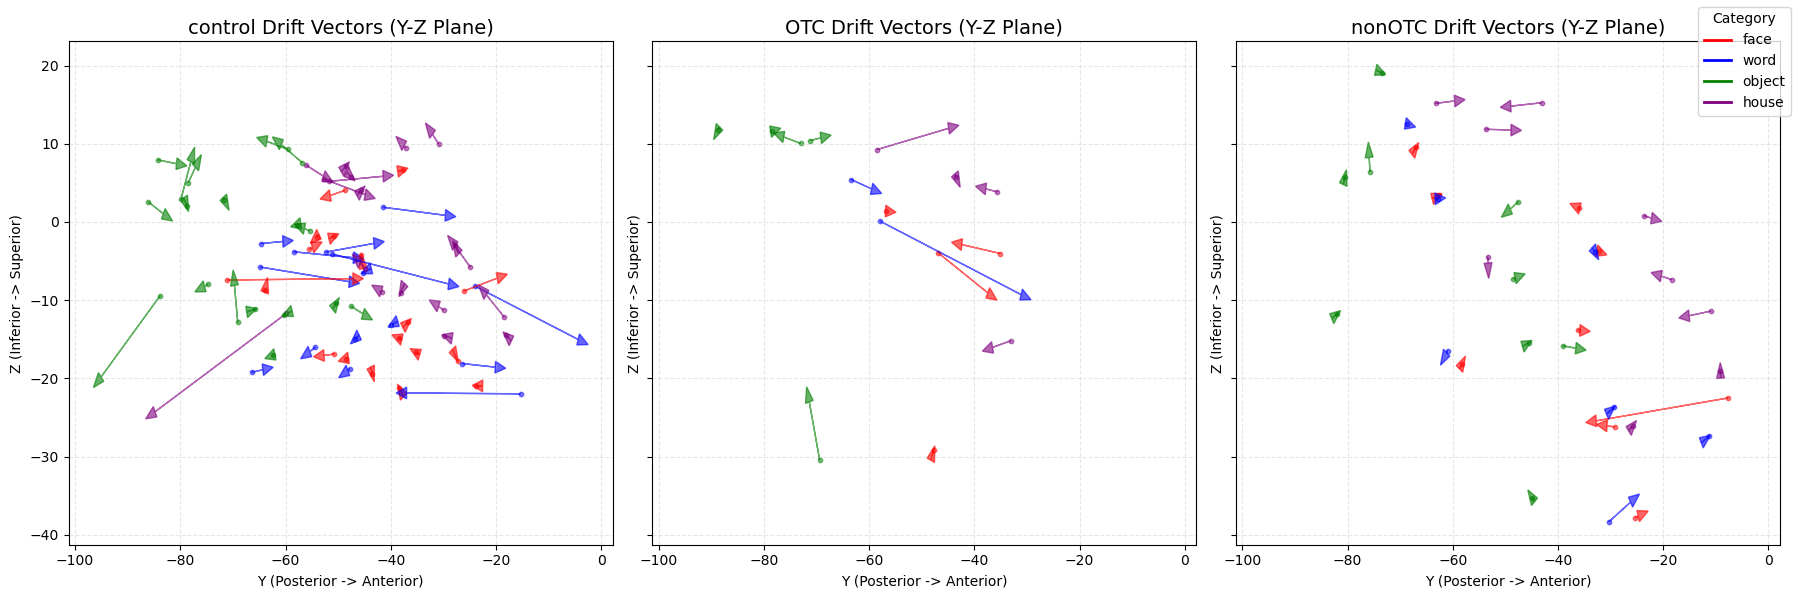

In [20]:
# CELL 13: Quiver Plot of ROI Drift
import matplotlib.pyplot as plt
import seaborn as sns

def plot_drift_quiver(results_dict, subjects_dict):
    # Setup
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
    groups = ['control', 'OTC', 'nonOTC']
    colors = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    
    # Store vectors for summary
    vectors = []

    print("Generating Quiver Plots...")
    
    for ax, target_group in zip(axes, groups):
        ax.set_title(f"{target_group} Drift Vectors (Y-Z Plane)", fontsize=14)
        ax.set_xlabel("Y (Posterior -> Anterior)")
        ax.set_ylabel("Z (Inferior -> Superior)")
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Plot Arrows
        for sid, rois in results_dict.items():
            info = subjects_dict.get(sid, {})
            
            # Group check
            g = info.get('group', 'control')
            if info.get('patient_status') == 'control': g = 'control'
            if g != target_group: continue
            
            for roi_key, sessions in rois.items():
                cat = roi_key.split('_')[1]
                hemi = roi_key.split('_')[0]
                col = colors.get(cat, 'gray')
                
                # Check weak signal flag (simulate the exclusion we discussed)
                # (You can implement the actual flag check if you stored it in the dict)
                # For now, we rely on the fact that 'results_dict' has the data
                
                sorted_ses = sorted(sessions.keys())
                if len(sorted_ses) < 2: continue
                
                # Get Coords
                c1 = sessions[sorted_ses[0]]['centroid']
                c2 = sessions[sorted_ses[-1]]['centroid']
                
                # Check for weak signal thresholds and SKIP if weak
                t1 = sessions[sorted_ses[0]].get('used_thresh', 0)
                t2 = sessions[sorted_ses[-1]].get('used_thresh', 0)
                if t1 < 1.65 or t2 < 1.65: continue
                
                # Plot Arrow (Y and Z coordinates usually capture the ventral stream shift best)
                # Y is usually index 1, Z is index 2 in MNI-ish space
                # Check your coordinate system! usually: x=L/R, y=P/A, z=I/S
                
                y1, z1 = c1[1], c1[2]
                y2, z2 = c2[1], c2[2]
                
                # Draw arrow
                ax.arrow(y1, z1, (y2-y1), (z2-z1), 
                         head_width=1.5, head_length=2, fc=col, ec=col, alpha=0.6, length_includes_head=True)
                
                # Add dot at start
                ax.scatter(y1, z1, c=col, s=10, alpha=0.5)

    # Legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=c, lw=2) for c in colors.values()]
    fig.legend(custom_lines, colors.keys(), loc='upper right', title="Category")
    
    plt.tight_layout()
    plt.show()

plot_drift_quiver(golarai_dynamic, ANALYSIS_SUBJECTS)

In [21]:
# Check which specific ROIs were flagged as WEAK_SIGNAL
weak_rois = df_diag[df_diag['flag'] == 'WEAK_SIGNAL'][['subject', 'group', 'roi', 'thresh_T1', 'thresh_T2']]
print("--- THE 10 EXCLUDED ROIs ---")
print(weak_rois.to_string(index=False))

# Check the category breakdown
print("\n--- BREAKDOWN BY CATEGORY ---")
print(weak_rois['roi'].apply(lambda x: x.split('_')[1]).value_counts())

--- THE 10 EXCLUDED ROIs ---
subject   group     roi  thresh_T1  thresh_T2
sub-004     OTC  l_word       1.64       2.20
sub-007  nonOTC  r_word       1.64       1.79
sub-008     OTC  l_word       1.64       1.81
sub-010     OTC  r_face       1.96       1.64
sub-010     OTC  r_word       2.24       1.64
sub-010     OTC r_house       1.64       1.64
sub-081  nonOTC  r_word       1.64       1.64
sub-027 control  r_word       2.37       1.64
sub-058 control  r_word       1.81       1.64
sub-062 control  r_word       1.71       1.64

--- BREAKDOWN BY CATEGORY ---
word     8
face     1
house    1
Name: roi, dtype: int64


In [22]:
# CELL 14: Full Data Printout
import pandas as pd

# 1. Configure Pandas to show EVERYTHING (no truncation)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

# 2. Print the 10 Excluded "Weak Signal" ROIs
print("======================================================================")
print("                       THE 10 EXCLUDED ROIS")
print("           (Reason: Top 20% Peak Z < 1.65 at T1 or T2)")
print("======================================================================")
weak_rois = df_diag[df_diag['flag'] == 'WEAK_SIGNAL'].sort_values(['group', 'subject'])
print(weak_rois[['subject', 'group', 'roi', 'thresh_T1', 'thresh_T2', 'drift_mm']].to_string(index=False))

print("\n\n")

# 3. Print the VALID Data (The ROIs used in your Quiver Plot & RDM)
print("======================================================================")
print("                       VALID DATA (INCLUDED)")
print("                 (Top 20% Peak Z >= 1.65 at T1 & T2)")
print("======================================================================")
valid_data = df_diag[df_diag['flag'] == ''].sort_values(['group', 'subject', 'roi'])
print(valid_data[['subject', 'group', 'roi', 'n_sessions', 'thresh_T1', 'thresh_T2', 'drift_mm']].to_string(index=False))

# 4. Quick Summary Stats on the VALID data
print("\n\n")
print("======================================================================")
print("                     SUMMARY STATS (VALID DATA ONLY)")
print("======================================================================")
print(valid_data.groupby('group')['drift_mm'].describe()[['count', 'mean', 'std', 'max']])

                       THE 10 EXCLUDED ROIS
           (Reason: Top 20% Peak Z < 1.65 at T1 or T2)
subject  group    roi    thresh_T1  thresh_T2  drift_mm
sub-004     OTC  l_word    1.64       2.20       18.8  
sub-008     OTC  l_word    1.64       1.81       54.2  
sub-010     OTC  r_face    1.96       1.64       11.0  
sub-010     OTC  r_word    2.24       1.64       20.0  
sub-010     OTC r_house    1.64       1.64       19.0  
sub-027 control  r_word    2.37       1.64        4.8  
sub-058 control  r_word    1.81       1.64        9.4  
sub-062 control  r_word    1.71       1.64        2.0  
sub-007  nonOTC  r_word    1.64       1.79       28.9  
sub-081  nonOTC  r_word    1.64       1.64       35.1  



                       VALID DATA (INCLUDED)
                 (Top 20% Peak Z >= 1.65 at T1 & T2)
subject  group    roi     n_sessions  thresh_T1  thresh_T2  drift_mm
sub-004     OTC   l_face      5         1.66       4.32        9.5  
sub-004     OTC  l_house      5         1.84  

Generating Rose Plots (Centered Vectors)...


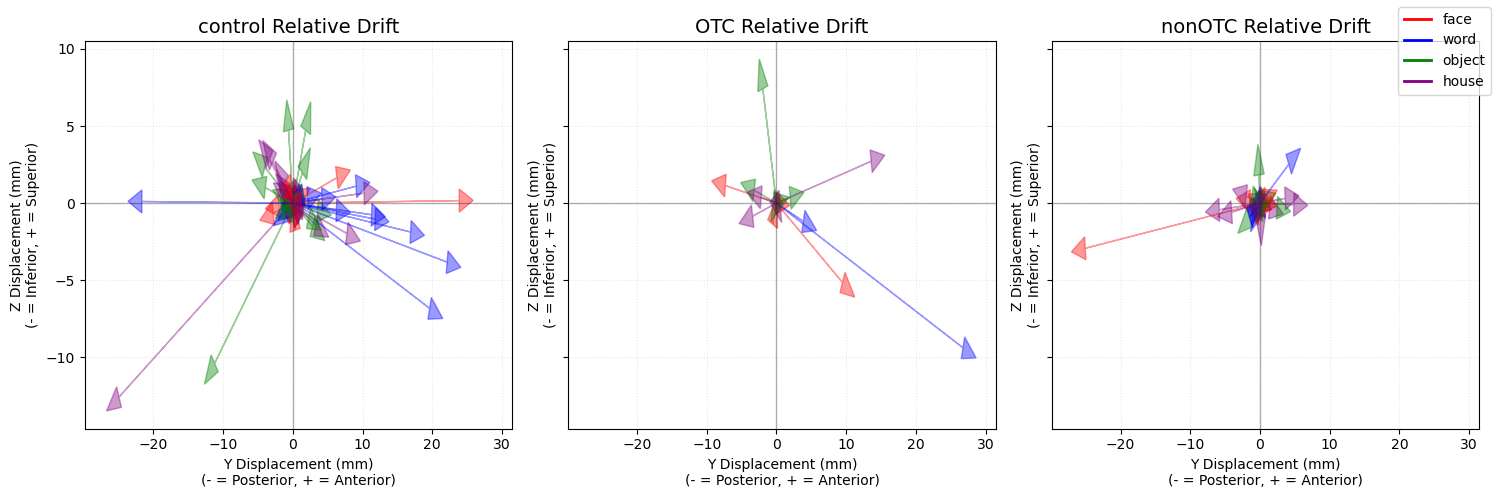

In [23]:
# CELL 15: "Rose Plot" (Relative Drift Vectors)
import matplotlib.pyplot as plt

def plot_drift_rose(results_dict, subjects_dict):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    groups = ['control', 'OTC', 'nonOTC']
    colors = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    
    print("Generating Rose Plots (Centered Vectors)...")
    
    for ax, target_group in zip(axes, groups):
        ax.set_title(f"{target_group} Relative Drift", fontsize=14)
        ax.set_xlabel("Y Displacement (mm)\n(- = Posterior, + = Anterior)")
        ax.set_ylabel("Z Displacement (mm)\n(- = Inferior, + = Superior)")
        ax.axhline(0, color='black', linewidth=1, alpha=0.3)
        ax.axvline(0, color='black', linewidth=1, alpha=0.3)
        ax.grid(True, linestyle=':', alpha=0.3)
        
        # Plot Arrows
        for sid, rois in results_dict.items():
            info = subjects_dict.get(sid, {})
            
            # Group filtering
            g = info.get('group', 'control')
            if info.get('patient_status') == 'control': g = 'control'
            if g != target_group: continue
            
            for roi_key, sessions in rois.items():
                cat = roi_key.split('_')[1]
                col = colors.get(cat, 'gray')
                
                sorted_ses = sorted(sessions.keys())
                if len(sorted_ses) < 2: continue
                
                # Check thresholds
                t1 = sessions[sorted_ses[0]].get('used_thresh', 0)
                t2 = sessions[sorted_ses[-1]].get('used_thresh', 0)
                if t1 < 1.65 or t2 < 1.65: continue
                
                # Get Coordinates
                c1 = sessions[sorted_ses[0]].get('centroid')
                c2 = sessions[sorted_ses[-1]].get('centroid')
                
                # CALCULATE RELATIVE VECTOR (Normalize Start to 0,0)
                dy = c2[1] - c1[1]
                dz = c2[2] - c1[2]
                
                # Plot arrow starting from (0,0)
                ax.arrow(0, 0, dy, dz, 
                         head_width=1.5, head_length=2, fc=col, ec=col, alpha=0.4, length_includes_head=True)

    # Legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=c, lw=2) for c in colors.values()]
    fig.legend(custom_lines, colors.keys(), loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_drift_rose(golarai_dynamic, ANALYSIS_SUBJECTS)

Generating Polar Rose Plots...


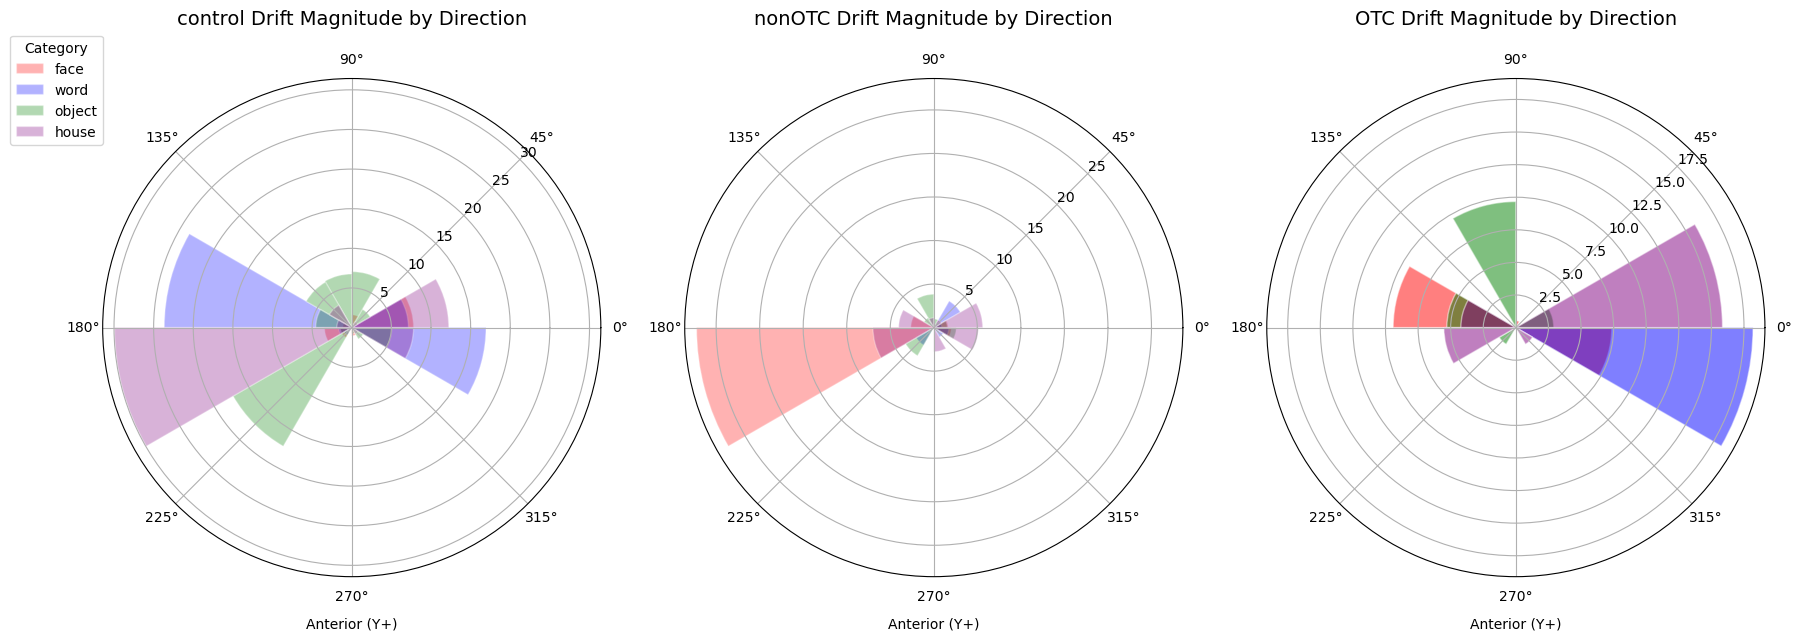

In [26]:
# CELL 18: Standard Polar Bar Plot (Rose Plot)
import numpy as np
import matplotlib.pyplot as plt

def plot_polar_rose(results_dict, subjects_dict):
    # --- Configuration ---
    # 12 bins = 30-degree slices (Standard clock-face style)
    N_BINS = 12 
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (2 * np.pi) / N_BINS  # Uniform width for all bars
    
    # Categories and Colors
    colors = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    
    # Setup Figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': 'polar'})
    groups = ['control', 'nonOTC', 'OTC']
    
    # Helper to convert Y,Z to Angle,Radius
    def cart2pol(y, z):
        radius = np.sqrt(y**2 + z**2)
        angle = np.arctan2(z, y) # Returns -pi to pi
        return angle, radius

    print("Generating Polar Rose Plots...")

    for ax, group in zip(axes, groups):
        ax.set_title(f"{group} Drift Magnitude by Direction", fontsize=14, pad=20)
        
        # Grid Setup
        ax.set_theta_zero_location("E") # 0 degrees = East (Anterior if Y-axis is horizontal)
        ax.set_theta_direction(1)       # Counter-clockwise
        
        # Collect all vectors for this group
        group_vectors = {'face': [], 'word': [], 'object': [], 'house': []}
        
        for sid, rois in results_dict.items():
            info = subjects_dict.get(sid, {})
            g = info.get('group', 'control')
            if info.get('patient_status') == 'control': g = 'control'
            if g != group: continue
            
            for roi_key, sessions in rois.items():
                cat = roi_key.split('_')[1]
                sorted_ses = sorted(sessions.keys())
                if len(sorted_ses) < 2: continue
                
                # Check Thresholds (Exclude Weak Signal)
                t1 = sessions[sorted_ses[0]].get('used_thresh', 0)
                t2 = sessions[sorted_ses[-1]].get('used_thresh', 0)
                if t1 < 1.65 or t2 < 1.65: continue
                
                # Calculate Vector
                c1 = sessions[sorted_ses[0]]['centroid']
                c2 = sessions[sorted_ses[-1]]['centroid']
                
                # Y (Posterior-Anterior) is usually axis 1, Z (Inferior-Superior) is axis 2
                dy = c2[1] - c1[1]
                dz = c2[2] - c1[2]
                
                angle, radius = cart2pol(dy, dz)
                group_vectors[cat].append((angle, radius))
        
        # Plotting Strategy
        # We plot stacked bars or overlaid bars. 
        # For clarity in this dense data, let's plot "Max Magnitude" in each bin per category
        
        # Initialize max radius per bin for scaling
        max_r_plot = 0
        
        for cat, vec_list in group_vectors.items():
            if not vec_list: continue
            
            angles = [v[0] for v in vec_list]
            radii = [v[1] for v in vec_list]
            
            # Digitize angles to find which bin they belong to
            bin_indices = np.digitize(angles, bin_edges) - 1
            
            # For each bin, calculate the MEAN magnitude of drift in that direction
            # (You could also use SUM or MAX depending on what story you want to tell)
            bin_values = np.zeros(N_BINS)
            for i in range(N_BINS):
                # Find all drifts that point in this direction
                indices = np.where(bin_indices == i)[0]
                if len(indices) > 0:
                    # Taking the MEAN drift distance of vectors in this bin
                    bin_values[i] = np.mean(np.array(radii)[indices])
            
            # Plot bars
            # Alpha is lower for OTC to see overlaps if multiple categories invade same space
            alpha = 0.5 if group == 'OTC' else 0.3 
            bars = ax.bar(bin_centers, bin_values, width=width, bottom=0.0, 
                          color=colors[cat], alpha=alpha, label=cat, edgecolor='white')
            
            if len(bin_values) > 0:
                max_r_plot = max(max_r_plot, np.max(bin_values))

        # Add custom labels to the grid
        ax.set_rlabel_position(45)
        ax.set_xlabel("Anterior (Y+)", labelpad=10)
        # Fix the radial limit so plots are comparable
        # ax.set_ylim(0, 20) # Uncomment to force same scale (e.g., 20mm)
        
        if group == 'control':
            ax.legend(loc='upper left', bbox_to_anchor=(-0.2, 1.1), title="Category")

    plt.tight_layout()
    plt.show()

plot_polar_rose(golarai_dynamic, ANALYSIS_SUBJECTS)

In [34]:
# CELL 25: Explicit Data Audit for OTC
import pandas as pd
import numpy as np

def audit_otc_data(results_dict, subjects_dict):
    audit_data = []
    
    print("--- OTC DATA AUDIT ---")
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        # Filter for OTC only
        if info.get('group') != 'OTC' or info.get('patient_status') == 'control': 
            continue
            
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            hemi = roi_key.split('_')[0]
            sorted_ses = sorted(sessions.keys())
            
            if len(sorted_ses) < 2:
                status = "EXCLUDED (Only 1 Session)"
                drift = np.nan
                t1, t2 = np.nan, np.nan
            else:
                # Get Stats
                s1 = sessions[sorted_ses[0]]
                s2 = sessions[sorted_ses[-1]]
                t1 = s1.get('used_thresh', 0)
                t2 = s2.get('used_thresh', 0)
                
                c1 = s1['centroid']
                c2 = s2['centroid']
                dy = c2[1] - c1[1]
                dz = c2[2] - c1[2]
                drift = np.sqrt(dy**2 + dz**2) # Magnitude
                
                # Determine Status
                if t1 < 1.65 or t2 < 1.65:
                    status = "EXCLUDED (Weak Signal)"
                else:
                    status = "INCLUDED"
            
            audit_data.append({
                'Subject': sid,
                'ROI': f"{hemi}_{cat}",
                'Cat': cat,
                'T1_Z': round(t1, 2) if not np.isnan(t1) else '-',
                'T2_Z': round(t2, 2) if not np.isnan(t2) else '-',
                'Drift_mm': round(drift, 1) if not np.isnan(drift) else '-',
                'Status': status
            })

    # Create DataFrame and Sort
    df_audit = pd.DataFrame(audit_data)
    # Sort by Category then Status to group them clearly
    df_audit = df_audit.sort_values(['Cat', 'Status', 'Subject'])
    
    # Print by Category
    for cat in ['face', 'word', 'object', 'house']:
        print(f"\n=== CATEGORY: {cat.upper()} ===")
        subset = df_audit[df_audit['Cat'] == cat]
        print(subset[['Subject', 'ROI', 'T1_Z', 'T2_Z', 'Drift_mm', 'Status']].to_string(index=False))
        
        # Summary Count
        valid_count = len(subset[subset['Status'] == 'INCLUDED'])
        print(f"Total Valid for Plot: {valid_count}")

audit_otc_data(golarai_dynamic, ANALYSIS_SUBJECTS)

--- OTC DATA AUDIT ---

=== CATEGORY: FACE ===
Subject  ROI    T1_Z  T2_Z  Drift_mm         Status        
sub-010 r_face  1.96  1.64     9.6   EXCLUDED (Weak Signal)
sub-004 l_face  1.66  4.32     9.4                 INCLUDED
sub-008 l_face  7.75  6.01     0.5                 INCLUDED
sub-017 r_face  2.83  3.15    12.8                 INCLUDED
sub-021 r_face  7.71  7.68     1.9                 INCLUDED
Total Valid for Plot: 4

=== CATEGORY: WORD ===
Subject  ROI    T1_Z  T2_Z  Drift_mm         Status        
sub-004 l_word  1.64  2.20    18.6   EXCLUDED (Weak Signal)
sub-008 l_word  1.64  1.81    54.2   EXCLUDED (Weak Signal)
sub-010 r_word  2.24  1.64    20.0   EXCLUDED (Weak Signal)
sub-017 r_word  2.40  2.52    30.4                 INCLUDED
sub-021 r_word  2.23  4.30     6.0                 INCLUDED
Total Valid for Plot: 2

=== CATEGORY: OBJECT ===
Subject   ROI     T1_Z  T2_Z  Drift_mm  Status 
sub-004 l_object  2.88  5.51    4.0    INCLUDED
sub-008 l_object  5.79  2.31    9.7    

--- EXTRACTING REAL DRIFT VECTORS ---


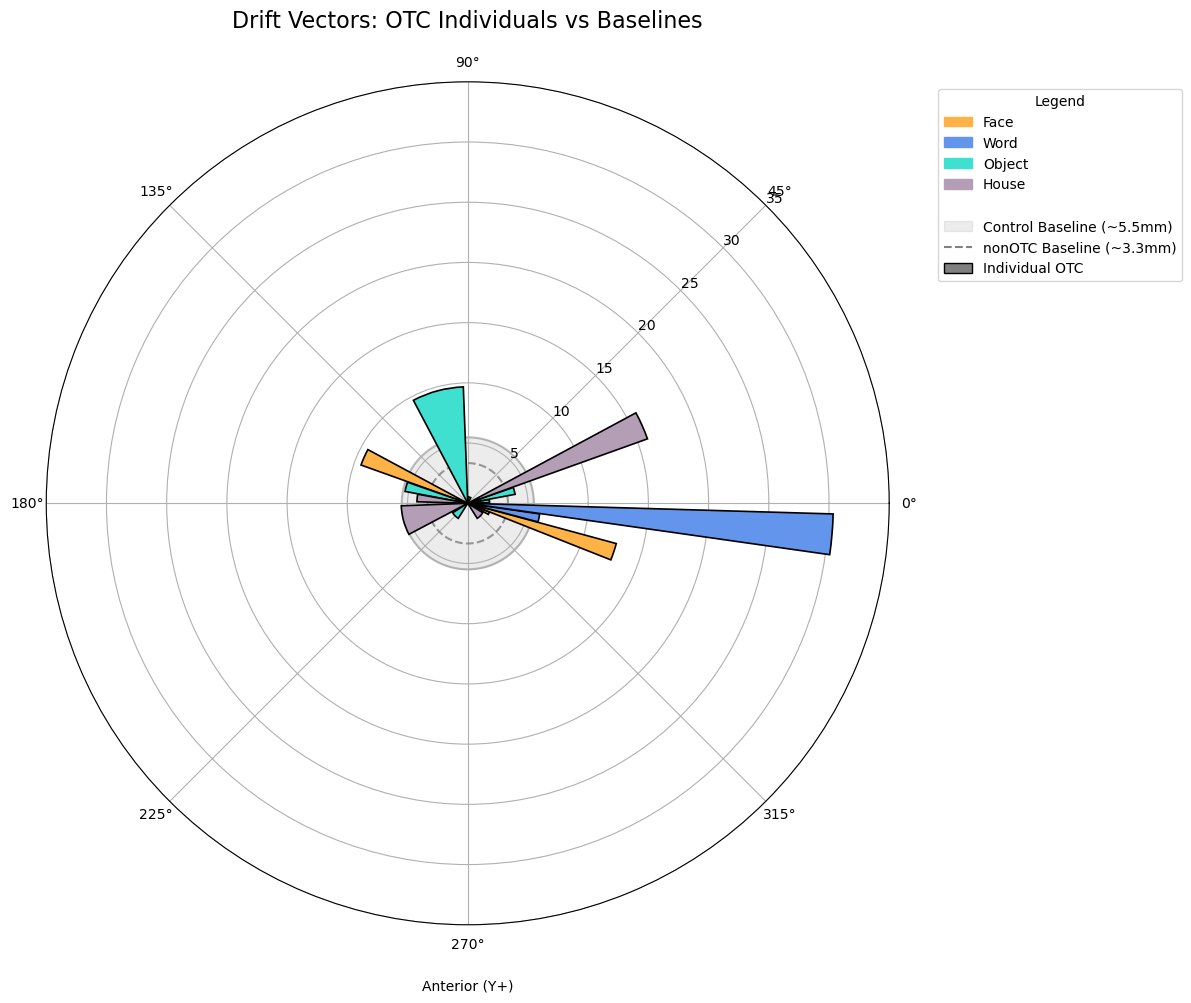

In [32]:
# CELL 49: INDEPENDENT PRODUCTION CODE (Dynamic Widths)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- CONFIGURATION ---
# How much of the 30-degree wedge to fill? (0.9 = 90% filled, 10% gap)
BIN_FILL_RATIO = 0.9 

# Pastel Palette
colors = {
    'face': '#FFB347',    # Pastel Peach
    'word': '#6495ED',    # Cornflower Blue
    'object': '#40E0D0',  # Turquoise
    'house': '#B39EB5'    # Pastel Purple
}
categories = ['face', 'word', 'object', 'house']

# --- HELPER FUNCTIONS ---
def cart2pol(y, z):
    return np.arctan2(z, y), np.sqrt(y**2 + z**2)

def get_bin_index(angle, bin_edges, n_bins):
    return min(np.digitize(angle, bin_edges) - 1, n_bins - 1)

# --- STEP 1: EXTRACT REAL DATA ---
def analyze_real_drift(results_dict, subjects_dict):
    data = []
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    
    print("--- EXTRACTING REAL DRIFT VECTORS ---")
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        group = info.get('group', 'control')
        if info.get('patient_status') == 'control': group = 'control'
        
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            sorted_ses = sorted(sessions.keys())
            if len(sorted_ses) < 2: continue
            
            s1 = sessions[sorted_ses[0]]
            s2 = sessions[sorted_ses[-1]]
            t1 = s1.get('used_thresh', 0)
            t2 = s2.get('used_thresh', 0)
            if t1 < 1.65 or t2 < 1.65: continue
            
            c1 = s1['centroid']
            c2 = s2['centroid']
            dy = c2[1] - c1[1]
            dz = c2[2] - c1[2]
            
            angle, radius = cart2pol(dy, dz)
            
            data.append({
                'Subject': sid, 'Group': group, 'Category': cat,
                'Radius': radius, 'Angle': angle,
                'Bin_Idx': get_bin_index(angle, bin_edges, N_BINS)
            })
            
    return pd.DataFrame(data)

# --- STEP 2: PLOTTING FUNCTION (DYNAMIC CLUSTER) ---
def plot_dynamic_cluster_rose(df):
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    full_bin_width = (2 * np.pi) / N_BINS
    
    # Global Baselines
    ctrl_mean = df[df['Group'] == 'control']['Radius'].mean()
    nonotc_mean = df[df['Group'] == 'nonOTC']['Radius'].mean()
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
    ax.set_title("Drift Vectors: OTC Individuals vs Baselines", fontsize=16, pad=20)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlabel_position(45)
    ax.set_xlabel("Anterior (Y+)", labelpad=20)
    ax.set_ylim(0, 35)

    # 1. BASELINES (Gray Circles)
    theta = np.linspace(0, 2*np.pi, 100)
    ax.fill_between(theta, 0, ctrl_mean, color='gray', alpha=0.15, zorder=0)
    ax.plot(theta, [ctrl_mean]*100, color='gray', linestyle='-', linewidth=1.5, alpha=0.5, zorder=1)
    ax.plot(theta, [nonotc_mean]*100, color='gray', linestyle='--', linewidth=1.5, alpha=0.8, zorder=2)

    # 2. OTC INDIVIDUALS (Dynamic Clustering)
    for b_idx in range(N_BINS):
        bin_center = bin_centers[b_idx]
        
        # Collect ALL OTC bars for this bin
        items = df[(df['Group'] == 'OTC') & (df['Bin_Idx'] == b_idx)].copy()
        
        if not items.empty:
            # Sort by Category so colors stay grouped together
            # Secondary sort by Radius for neatness
            items['Cat_Sort'] = pd.Categorical(items['Category'], categories=categories, ordered=True)
            items = items.sort_values(['Cat_Sort', 'Radius'])
            
            n_items = len(items)
            
            # --- DYNAMIC WIDTH CALCULATION ---
            # We split the ENTIRE usable bin width among the active items
            # This ensures maximum thickness
            total_usable_width = full_bin_width * BIN_FILL_RATIO
            individual_bar_width = total_usable_width / n_items
            
            # Calculate start point to center the cluster in the bin
            cluster_start = bin_center - (total_usable_width / 2) + (individual_bar_width / 2)
            
            for k, (_, row) in enumerate(items.iterrows()):
                theta = cluster_start + (k * individual_bar_width)
                
                # Plot Bar
                # width = individual_bar_width * 0.95 (leave tiny gap between adjacent bars)
                ax.bar(theta, row['Radius'], width=individual_bar_width * 0.95, bottom=0.0,
                       color=colors[row['Category']], alpha=1.0, edgecolor='black', 
                       linewidth=1.2, zorder=10)

    # Legend
    legend_cats = [mpatches.Patch(color=c, label=cat.title()) for cat, c in colors.items()]
    style_legend = [
        mpatches.Patch(facecolor='gray', alpha=0.15, edgecolor='gray', label=f'Control Baseline (~{ctrl_mean:.1f}mm)'),
        plt.Line2D([0], [0], color='gray', linestyle='--', label=f'nonOTC Baseline (~{nonotc_mean:.1f}mm)'),
        mpatches.Patch(facecolor='gray', alpha=1.0, edgecolor='black', label='Individual OTC'),
    ]
    ax.legend(handles=legend_cats + [mpatches.Patch(visible=False)] + style_legend, 
              loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend")
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
if 'golarai_dynamic' in locals():
    df_drift_real = analyze_real_drift(golarai_dynamic, ANALYSIS_SUBJECTS)
    plot_dynamic_cluster_rose(df_drift_real)
else:
    print("Error: 'golarai_dynamic' not found. Please re-run the Top 20% extraction cell.")